## Exercise 18

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

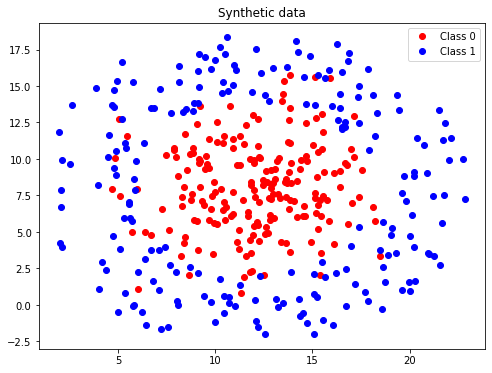

In [ ]:
# Synthetic data
m_=200
mu = np.array([12, 8])
sigma_ = np.array([[9,0],[0,9]])
X1 = np.random.multivariate_normal(mu,sigma_,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 6 + np.random.uniform(0,5,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)



plt.figure(figsize=(8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label ='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label ='Class 1')
plt.title('Synthetic data')
plt.legend()
plt.show()

In [ ]:
# Trainning data
X = np.concatenate((X1,X2),0)
y = np.concatenate((-np.ones((m_,1)),np.ones((m_,1))),0)
m = X.shape[0]
n = np.unique(y).shape[0]

In [ ]:
# Split training data to train set and validation set
def train_val_split(X,y):
  m = X.shape[0]
  order = np.arange(m)
  np.random.shuffle(order)
  m_train = int(0.8*m)
  m_val = m - m_train
  train_ind = order[:m_train]
  val_ind = order[m_train:]
  X_train = X[train_ind,:]
  y_train = y[train_ind,:]
  X_val = X[val_ind,:]
  y_val = y[val_ind,:] 
  return X_train,y_train,X_val,y_val
X_train,y_train,X_val,y_val=train_val_split(X,y)

#### **Use train set to build model**

**Kernel:**

$$\small \text{RBF Kernel (Radial Basis Function): $\mathcal k(x,x^{'}) = \mathrm{e}^{\frac{-||x-x^{'}||^{2}}{2\sigma^{2}}} \\ 
K = \underbrace{\begin{vmatrix}K(x^{1},x^{1}) & K(x^{1},x^{2}) & .. & K(x^{1},x^{m}) \\K(x^{2},x^{1}) & K(x^{2},x^{2}) & .. & K(x^{2},x^{m})\\: & :& :\\K(x^{m},x^{1}) & K(x^{m},x^{2}) & .. & K(x^{m},x^{m})\end{vmatrix}}_{m \times m} $}$$

In [ ]:
# RBF Kernel
def rbf_kernel(X,sigma):
  m = X.shape[0]
  K = np.ones((m,m))
  for i in range(m):
    for j in range(m):
      K[i,j]=(X[i,:]-X[j,:])@(X[i,:]-X[j,:])
  K = np.exp(-K/(2*sigma**2))
  return K

**Dual Lagrangian Optimization with Slack variable:**
$$ \mathcal W(\alpha) = \min_{\alpha} \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}\mathcal k(x,x^{'}) - \sum_{i=1}^{m}\alpha_{i} $$
$$\text{Such that: $0 \le \alpha_{i} \le C, i \in 1...m \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)} = 0 $}$$

$$
Q=y^{(i)}y^{(j)}\mathcal k(x,x^{'}) ; 
c = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{m \times 1} ; 
A = \underbrace{\begin{vmatrix}-1 & 0 & .. & 0 \\0 & -1 & .. & 0\\: & :& :\\0 & 0 & .. & -1\\1 & 0 & .. & 0 \\0 & 1 & .. & 0\\: & :& :\\0 & 0 & .. & 1\end{vmatrix}}_{2m \times m} ; 
b =\underbrace{\begin{vmatrix}0\\0 \\:\\0\\C\\C \\:\\C\end{vmatrix}}_{2m \times 1} ; 
E = \underbrace{\begin{vmatrix}y_{1} & y_{2} & .. & y_{m}\end{vmatrix}}_{1 \times m} ; d = 0
$$

In [ ]:
# Set Q,c,A,b,E,d
sigma = 1
C = 2
def set_param(X,y,sigma,C):
  m = X.shape[0]
  Q = (y@y.T)*rbf_kernel(X,sigma)
  c = -np.ones((m,1))
  A = np.concatenate((-np.eye(m),np.eye(m)),0)
  b = np.concatenate((np.zeros((m,1)),np.ones((m,1))*C),0)
  E = y.T
  d = np.zeros((1,1))
  return Q,c,A,b,E,d
Q,c,A,b,E,d = set_param(X_train,y_train,sigma,C)

**General Quadratic Programming**
$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$
- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

In [ ]:
# cvxopt.solvers.qp function
def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    args = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(*args)
    return np.array(sol['x']).reshape((Q.shape[1],))
opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)

**Find b**:

$\mathcal S \small \text{ is the set of indexes of the support vectors: } \mathcal S = \{ i \in 1..m | \alpha_{i} > 0 \}; N_{\mathcal S} = len(\mathcal S)$

$$b =\frac{1}{N_{\mathcal S}}\sum_{i \in \mathcal S} \left(y^{(i)} - \sum_{j \in \mathcal S}\alpha_{j}y^{(j)} \mathcal k(x,x^{'}) \right)$$

In [ ]:
# Find b from opt_params
def find_b(X,y,alpha,sigma):
  S = np.where(alpha[alpha>1e-5])[0]
  X_s = X[S,:]
  y_s = y[S]
  alpha_s = alpha[S].reshape(-1,1)
  b = (y_s - ((alpha_s*y_s).T*rbf_kernel(X_s,sigma)).sum(axis=1,keepdims=True)).mean()
  return b
b = find_b(X_train,y_train,opt_params,sigma)

**Make the prediction**
$$\mathcal h_{w,b}(x) = 
\begin{cases}
+ 1 \quad \text{$w^{T}x + b \ge 0$} \\ 
-1 \quad \text{otherwise}
\end{cases} \\
\text{Note that: $ w^{T}x + b = \sum_{i=1}^{m}\alpha_{j}y^{(j)}\mathcal K(x^{(i)},x^{(j)}) +b $}
$$

In [ ]:
def rbf_kernel_(x,xprime,sigma):
  return np.exp((-(x-xprime)@(x-xprime))/(2*sigma**2))

def svm_predict(x,X,y,alpha,sigma):
  results = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    results[i]=0
    for j in range(X.shape[0]):
      results[i]+=alpha[j]*y[j,0]*rbf_kernel_(x[i,:],X[j,:],sigma)
    results[i]+= b
  return np.where(results>=0,1,-1)

In [ ]:
def accuracy(X,y,alpha,sigma):
  y_pred = svm_predict(X,X,y,alpha,sigma)
  accuracy = (y_pred==y).mean()
  return accuracy

In [ ]:
# Trainning accuracy
train_accuracy = accuracy(X_train,y_train,opt_params,sigma)
val_accuracy = accuracy(X_val,y_val,opt_params,sigma)
print('Train accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)

Train accuracy: 0.953125
Validation accuracy: 0.8375


In [ ]:
# Find best sigma & C using cross validation
sigmas = np.linspace(1,3,3)
Cs = np.linspace(1,10,10)

def grid(X_train,y_train,X_val,y_val,sigmas,Cs):
  train_acc = []
  val_acc = []
  params = []
  for sigma in sigmas:
    for C in Cs:
      
      Q,c,A,b,E,d = set_param(X_train,y_train,sigma,C)
      opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)
      b = find_b(X_train,y_train,opt_params,sigma)
      
      train_acc.append(accuracy(X_train,y_train,opt_params,sigma))
      val_acc.append(accuracy(X_val,y_val,opt_params,sigma))
      params.append([sigma,C]) 
  return np.array(train_acc),np.array(val_acc),np.array(params)
train_acc,val_acc,params=grid(X_train,y_train,X_val,y_val,sigmas,Cs)

In [ ]:
# Best sigma & C
best_index = np.argmax(val_acc)
best_val_acc = val_acc[best_index]
best_sigma = params[best_index][0]
best_C= params[best_index][1]
print('Best Validation accuracy:',best_val_acc,'| Best Sigma:',best_sigma,'| Best C',best_C)

Best Validation accuracy: 0.875 | Best Sigma: 1.0 | Best C 3.0


Text(0.5, 1.0, 'Sigma = 3')

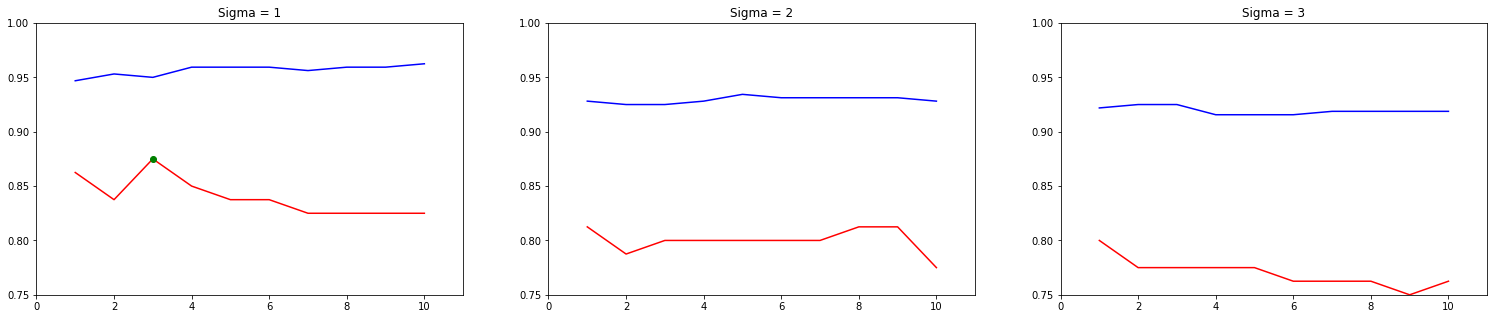

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [26,5]

fig,(ax1,ax2,ax3) = plt.subplots(1,3)
maxx=11
minx=0
maxy=1
miny=0.75

i = int(train_acc.shape[0]/3)
ax1.plot(Cs,train_acc[:i],'b-')
ax1.plot(Cs,val_acc[:i],'r-')
if best_sigma == 1:
  ax1.plot(best_C,best_val_acc,'go')
ax1.set_xlim(minx,maxx)
ax1.set_ylim(miny,maxy)
ax1.set_title('Sigma = 1')


ax2.plot(Cs,train_acc[i:2*i],'b-')
ax2.plot(Cs,val_acc[i:2*i],'r-')
if best_sigma == 2:
  ax2.plot(best_C,best_val_acc,'go')
ax2.set_xlim(minx,maxx)
ax2.set_ylim(miny,maxy)
ax2.set_title('Sigma = 2')

ax3.plot(Cs,train_acc[2*i:],'b-')
ax3.plot(Cs,val_acc[2*i:],'r-')
if best_sigma == 3:
  ax3.plot(best_C,best_val_acc,'go')
ax3.set_xlim(minx,maxx)
ax3.set_ylim(miny,maxy)
ax3.set_title('Sigma = 3')

In [ ]:
# Plot the classification regions